Importing Libraries

In [1]:
import sys
sys.path.append('/Users/senzari/Machine_Learning/stats/src/stats/match_stats.py')
sys.path.append('/anaconda/envs/stats/lib/python3.5/site-packages')
sys.path.append('/Users/senzari/Machine_Learning/stats/src/stats/model_libs.py')
print(sys.path)

['', '//anaconda/lib/python27.zip', '//anaconda/lib/python2.7', '//anaconda/lib/python2.7/plat-darwin', '//anaconda/lib/python2.7/plat-mac', '//anaconda/lib/python2.7/plat-mac/lib-scriptpackages', '//anaconda/lib/python2.7/lib-tk', '//anaconda/lib/python2.7/lib-old', '//anaconda/lib/python2.7/lib-dynload', '/Users/senzari/.local/lib/python2.7/site-packages', '/anaconda/lib/python2.7/site-packages/Sphinx-1.3.1-py2.7.egg', '/anaconda/lib/python2.7/site-packages/setuptools-21.2.1-py2.7.egg', '//anaconda/lib/python2.7/site-packages', '//anaconda/lib/python2.7/site-packages/aeosa', '//anaconda/lib/python2.7/site-packages/IPython/extensions', '/Users/senzari/.ipython', '/Users/senzari/Machine_Learning/stats/src/stats/match_stats.py', '/anaconda/envs/stats/lib/python3.5/site-packages', '/Users/senzari/Machine_Learning/stats/src/stats/model_libs.py']


In [2]:
import datetime

import match_stats
import mysql.connector
import pandas as pd
from pandas.tools.plotting import scatter_matrix
import numpy as np
import matplotlib
%matplotlib inline
import renders as rs
from sklearn import grid_search
from sklearn.cross_validation import train_test_split
from sklearn import cross_validation
from sklearn.metrics import make_scorer, mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVC
from sklearn.metrics import f1_score
from sklearn.decomposition import PCA
from IPython.display import display # Allows the use of display() for DataFrames
from sklearn import preprocessing

import model_libs

Find all matches

In [3]:
cnx = mysql.connector.connect(user='root', password='',
                              host='127.0.0.1',
                              database='mls')
cursor = cnx.cursor(dictionary=True, buffered=True)

match_details = pd.read_sql('SELECT * FROM home_away_coverage_2', cnx)
query = "SELECT id FROM teams"
cursor.execute(query)

round_number = 24
features = {}

upcoming_matches = pd.read_sql("SELECT matches.id as 'match_id', matches.scheduled, matches.home_id, matches.away_id, teams1.full_name AS 'home_team', teams2.full_name AS 'away_team' FROM matches LEFT JOIN teams teams1 ON matches.home_id = teams1.id LEFT JOIN teams teams2 ON matches.away_id = teams2.id WHERE status = 'scheduled'", cnx)
previous_matches = pd.read_sql("SELECT * FROM matches WHERE status = 'closed'", cnx)

print(len(match_details.index))

224


In [52]:
pd.crosstab(match_details['home_score'], 
            match_details.replace({'home_points': {0: 'lose', 1: 'tie', 3: 'win'}})['home_points']).apply(lambda r: r/len(match_details), axis=1)


home_points,lose,tie,win
home_score,,,
0,0.071429,0.066964,0.000000
1,0.062500,0.160714,0.133929
2,0.017857,0.093750,0.183036
3,0.008929,0.008929,0.120536
4,0.000000,0.004464,0.049107
5,0.000000,0.000000,0.017857


In [53]:
pd.crosstab(match_details['away_score'], 
            match_details.replace({'away_points': {0: 'lose', 1: 'tie', 3: 'win'}})['away_points']).apply(lambda r: r/len(match_details), axis=1)

away_points,lose,tie,win
away_score,,,
0,0.281250,0.066964,0.000000
1,0.151786,0.160714,0.031250
2,0.058036,0.093750,0.066964
3,0.013393,0.008929,0.035714
4,0.000000,0.004464,0.022321
7,0.000000,0.000000,0.004464


In [4]:
training_list = []

for team in cursor:
    for i in range(2, round_number):

        print("ROUND {} :: TEAM ID {}".format(i, team["id"]))
        cur_matches = match_details.loc[
            ((match_details['home_id'] == team["id"]) | (match_details['away_id'] == team["id"])) &
            ((match_details['round'] == i))]

        if not cur_matches.empty:
            for c, cur_match in cur_matches.iterrows():
                """ Better Solution for this?  Basically pulling out a Series but the create_match function is expecting a DF
                # have to convert it back to a DF in order to not pull the same entry if there are multiple games in the week """
                temp = pd.DataFrame([])
                df = temp.append(cur_match, ignore_index=True)
                match_result = match_stats.create_match(team["id"], df, match_details, i, False, True)

                if match_result is not None:
                    training_list.append(match_result)                  

columns = ['match_id', 'team_id', 'team_name', 'opp_id', 'opp_name', 'scheduled', 'games_played', 
           # Non-Feature Columns
           'is_home', 'avg_points', 'goals_for', 'goals_against', 'avg_goals', 'margin', 'goal_diff',
           'win_percentage', 'sos', 'opp_is_home', 'opp_avg_points', 'opp_avg_goals', 'opp_margin',
           'opp_goal_diff', 'opp_win_percentage', 'opp_opp_record',
           # Extended Feature Columns
           'home_possession', 'away_possession', 'home_attacks', 'away_attacks', 'home_fouls', 'away_fouls',
           'home_yellow_card', 'away_yellow_card', 'home_corner_kicks', 'away_corner_kicks',
           'home_shots_on_target', 'away_shots_on_target', 'home_ball_safe', 'away_ball_safe',
           'home_shots_total', 'away_shots_total',
           'points']  # Target Columns - #'goals', 'opp_goals'

training_data = pd.DataFrame(training_list, columns=columns)
target_col = 'points'
ignore_cols = ['match_id', 'team_id', 'team_name', 'opp_id', 'opp_name', 'scheduled', 'goals_for', 'goals_against', 'games_played']
td = model_libs._clone_and_drop(training_data, ignore_cols)
print("Loaded...")

ROUND 2 :: TEAM ID 21
ROUND 3 :: TEAM ID 21
ROUND 4 :: TEAM ID 21
ROUND 5 :: TEAM ID 21
ROUND 6 :: TEAM ID 21
ROUND 7 :: TEAM ID 21
ROUND 8 :: TEAM ID 21
ROUND 9 :: TEAM ID 21
ROUND 10 :: TEAM ID 21
ROUND 11 :: TEAM ID 21
ROUND 12 :: TEAM ID 21
ROUND 13 :: TEAM ID 21
ROUND 14 :: TEAM ID 21
ROUND 15 :: TEAM ID 21
ROUND 16 :: TEAM ID 21
ROUND 17 :: TEAM ID 21
ROUND 18 :: TEAM ID 21
ROUND 19 :: TEAM ID 21
ROUND 20 :: TEAM ID 21
ROUND 21 :: TEAM ID 21
ROUND 22 :: TEAM ID 21
ROUND 23 :: TEAM ID 21
ROUND 2 :: TEAM ID 22
ROUND 3 :: TEAM ID 22
ROUND 4 :: TEAM ID 22
ROUND 5 :: TEAM ID 22
ROUND 6 :: TEAM ID 22
ROUND 7 :: TEAM ID 22
ROUND 8 :: TEAM ID 22
ROUND 9 :: TEAM ID 22
ROUND 10 :: TEAM ID 22
ROUND 11 :: TEAM ID 22
ROUND 12 :: TEAM ID 22
ROUND 13 :: TEAM ID 22
ROUND 14 :: TEAM ID 22
ROUND 15 :: TEAM ID 22
ROUND 16 :: TEAM ID 22
ROUND 17 :: TEAM ID 22
ROUND 18 :: TEAM ID 22
ROUND 19 :: TEAM ID 22
ROUND 20 :: TEAM ID 22
ROUND 21 :: TEAM ID 22
ROUND 22 :: TEAM ID 22
ROUND 23 :: TEAM ID 22
ROUN

/Users/senzari/.local/lib/python2.7/site-packages/numpy/lib/nanfunctions.py:675: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)


ROUND 9 :: TEAM ID 23
ROUND 10 :: TEAM ID 23
ROUND 11 :: TEAM ID 23
ROUND 12 :: TEAM ID 23
ROUND 13 :: TEAM ID 23
ROUND 14 :: TEAM ID 23
ROUND 15 :: TEAM ID 23
ROUND 16 :: TEAM ID 23
ROUND 17 :: TEAM ID 23
ROUND 18 :: TEAM ID 23
ROUND 19 :: TEAM ID 23
ROUND 20 :: TEAM ID 23
ROUND 21 :: TEAM ID 23
ROUND 22 :: TEAM ID 23
ROUND 23 :: TEAM ID 23
ROUND 2 :: TEAM ID 24
ROUND 3 :: TEAM ID 24
ROUND 4 :: TEAM ID 24
ROUND 5 :: TEAM ID 24
ROUND 6 :: TEAM ID 24
ROUND 7 :: TEAM ID 24
ROUND 8 :: TEAM ID 24
ROUND 9 :: TEAM ID 24
ROUND 10 :: TEAM ID 24
ROUND 11 :: TEAM ID 24
ROUND 12 :: TEAM ID 24
ROUND 13 :: TEAM ID 24
ROUND 14 :: TEAM ID 24
ROUND 15 :: TEAM ID 24
ROUND 16 :: TEAM ID 24
ROUND 17 :: TEAM ID 24
ROUND 18 :: TEAM ID 24
ROUND 19 :: TEAM ID 24
ROUND 20 :: TEAM ID 24
ROUND 21 :: TEAM ID 24
ROUND 22 :: TEAM ID 24
ROUND 23 :: TEAM ID 24
ROUND 2 :: TEAM ID 25
ROUND 3 :: TEAM ID 25
ROUND 4 :: TEAM ID 25
ROUND 5 :: TEAM ID 25
ROUND 6 :: TEAM ID 25
ROUND 7 :: TEAM ID 25
ROUND 8 :: TEAM ID 25
ROUN

In [5]:
display(td.describe())

,is_home,avg_points,avg_goals,margin,goal_diff,win_percentage,sos,opp_is_home,opp_avg_points,opp_avg_goals,...,away_yellow_card,home_corner_kicks,away_corner_kicks,home_shots_on_target,away_shots_on_target,home_ball_safe,away_ball_safe,home_shots_total,away_shots_total,points
count,428.000000,428.000000,428.000000,428.000000,428.000000,428.000000,428.000000,428.000000,428.000000,428.000000,...,428.000000,428.000000,428.000000,428.000000,428.000000,428.000000,428.000000,428.000000,428.000000,428.000000
mean,0.500000,0.988318,1.021028,-0.422897,-0.016355,0.500911,1.169057,0.500000,0.988318,1.021028,...,1.789090,5.513474,4.033948,5.366416,4.072031,90.363995,90.076934,10.055656,7.893072,1.329439
std,0.500585,0.578583,0.536296,0.711984,3.947218,0.172215,0.317689,0.500585,0.578583,0.536296,...,0.704028,1.964701,1.548320,1.699190,1.274190,22.355340,18.834093,2.972888,2.009699,1.241881
min,0.000000,0.000000,0.000000,-3.000000,-14.000000,0.000000,0.185185,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,1.000000,1.000000,-1.000000,-2.000000,0.406250,0.991394,0.000000,1.000000,1.000000,...,1.500000,4.500000,3.250000,4.787500,3.500000,85.800000,88.583333,9.400000,7.000000,0.000000
50%,0.500000,1.000000,1.000000,0.000000,0.000000,0.500000,1.166667,0.500000,1.000000,1.000000,...,1.818182,5.571429,4.000000,5.600000,4.145833,92.464286,93.333333,10.500000,8.250000,1.000000
75%,1.000000,1.000000,1.000000,0.000000,2.000000,0.595211,1.353582,1.000000,1.000000,1.000000,...,2.000000,6.500000,5.000000,6.400000,4.800000,102.571429,98.000000,12.000000,8.833333,3.000000
max,1.000000,3.000000,4.000000,3.000000,13.000000,1.000000,2.166667,1.000000,3.000000,4.000000,...,4.000000,12.000000,8.000000,9.000000,8.000000,122.000000,128.000000,16.000000,13.000000,3.000000


In [6]:
def train_classifier(clf, X_train, y_train):
    clf.fit(X_train, y_train)


def predict_labels(clf, features, target):
    y_pred = clf.predict(features)
    #print(' ~~~~~~~~~~~~~~~~~~~~~~~ ')
    #print(y_pred)
    #print(target.values)
    print(' ~~~~~~~~~~~~~~~~~~~~~~~ ')
    return f1_score(target.values, y_pred, average="macro")


def train_predict(clf, X_train, y_train, X_test, y_test):
    train_classifier(clf, X_train, y_train)
    train_f1_score = predict_labels(clf, X_train, y_train)
    test_f1_score = predict_labels(clf, X_test, y_test)

    return train_f1_score, test_f1_score

In [7]:
(y, X) = model_libs._extract_target(td, target_col)
print(type(X))
# SVM Model with ALL FEATURES NOT Normalized
parameters = {'kernel': ('linear', 'rbf'), 'C': [1, 10]}
svr = SVC()
clf_1 = grid_search.GridSearchCV(svr, parameters)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
train_f1_score, test_f1_score = train_predict(clf_1, X_train, y_train, X_test, y_test)
print("F1 score for training set: {}".format(train_f1_score))
print("F1 score for test set: {}".format(test_f1_score))

<class 'pandas.core.frame.DataFrame'>
 ~~~~~~~~~~~~~~~~~~~~~~~ 
 ~~~~~~~~~~~~~~~~~~~~~~~ 
F1 score for training set: 0.571918444728
F1 score for test set: 0.470544157003


In [113]:
"""(y, X) = model_libs._extract_target(td, target_col)
# Because of negative numbers
#min_max_scaler = preprocessing.MinMaxScaler()
#norm_data = min_max_scaler.fit_transform(X)
pd.set_option('display.max_columns', None)
norm_data = X.copy(deep=True)
norm_data = norm_data.apply(lambda x: (x - x.min()) / (x.max() - x.min()))

print(norm_data)"""

     is_home  avg_points  avg_goals    margin  goal_diff  win_percentage  \
0          0    1.000000       0.50  0.833333   0.592593        1.000000   
1          1    0.333333       0.25  0.166667   0.407407        0.500000   
2          0    0.666667       0.25  0.333333   0.481481        0.666667   
3          1    0.666667       0.25  0.500000   0.592593        0.777778   
4          1    0.666667       0.25  0.500000   0.592593        0.717391   
5          0    0.333333       0.25  0.500000   0.592593        0.678571   
6          1    0.333333       0.25  0.500000   0.592593        0.678571   
7          0    0.666667       0.25  0.500000   0.703704        0.763158   
8          0    0.333333       0.25  0.500000   0.592593        0.690476   
9          0    0.333333       0.25  0.333333   0.444444        0.630435   
10         1    0.333333       0.25  0.333333   0.407407        0.580000   
11         1    0.333333       0.25  0.333333   0.407407        0.580000   
12         0

(428, 30)


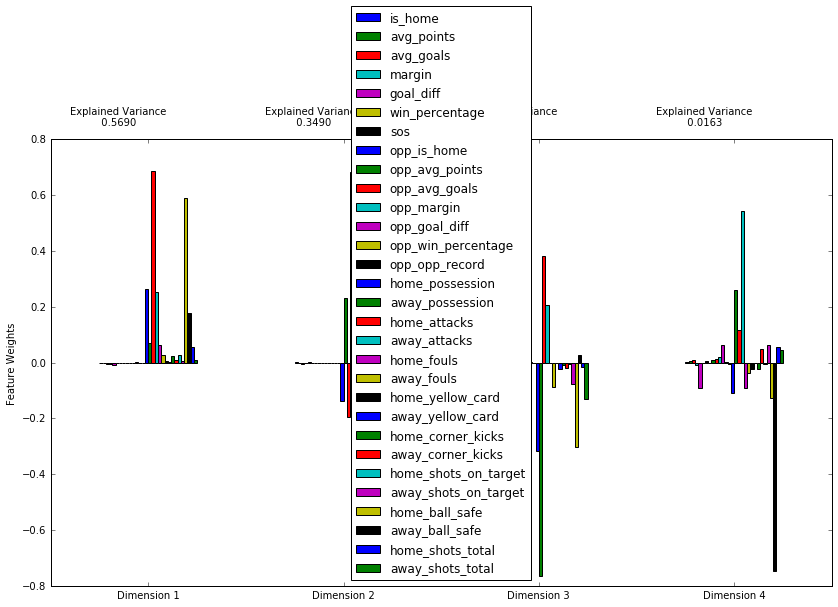

In [11]:
print(X.shape)
import renders as rs
pca = PCA(n_components=4)
pca.fit(X)
# Generate PCA results plot
pca_results = rs.pca_results(X, pca)

Essentially the first feature is opposite of the second and the 3rd feature is opposite of the 4th.  Home vs Away.
How to make SOS pertinent.

In [ ]:
secondary_features = ['match_id', 'team_id', 'team_name', 'opp_id', 'opp_name', 'scheduled']

In [114]:
display(norm_data.describe())

,is_home,avg_points,avg_goals,margin,goal_diff,win_percentage,sos,opp_is_home,opp_avg_points,opp_avg_goals,opp_margin,opp_goal_diff,opp_win_percentage,opp_opp_record,home_possession,away_possession,home_attacks,away_attacks,home_fouls,away_fouls,home_yellow_card,away_yellow_card,home_corner_kicks,away_corner_kicks,home_shots_on_target,away_shots_on_target,home_ball_safe,away_ball_safe,home_shots_total,away_shots_total
count,428.000000,428.000000,428.000000,428.000000,428.000000,428.000000,428.000000,428.000000,428.000000,428.000000,428.000000,428.000000,428.000000,428.000000,428.000000,428.000000,428.000000,428.000000,428.000000,428.000000,428.000000,428.000000,428.000000,428.000000,428.000000,428.000000,428.000000,428.000000,428.000000,428.000000
mean,0.500000,0.329439,0.255257,0.429517,0.517913,0.500911,0.496534,0.500000,0.329439,0.255257,0.429517,0.517913,0.500911,0.500703,0.798625,0.710303,0.694831,0.659557,0.510654,0.569772,0.287079,0.447272,0.459456,0.504244,0.596268,0.509004,0.740688,0.703726,0.628478,0.607159
std,0.500585,0.192861,0.134074,0.118664,0.146193,0.172215,0.160329,0.500585,0.192861,0.134074,0.118664,0.146193,0.172215,0.171907,0.181506,0.138214,0.179331,0.151457,0.142779,0.149325,0.129306,0.176007,0.163725,0.193540,0.188799,0.159274,0.183240,0.147141,0.185805,0.154592
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.333333,0.250000,0.333333,0.444444,0.406250,0.406872,0.000000,0.333333,0.250000,0.333333,0.444444,0.406250,0.406250,0.806452,0.704545,0.650350,0.633392,0.456522,0.498377,0.200000,0.375000,0.375000,0.406250,0.531944,0.437500,0.703279,0.692057,0.587500,0.538462
50%,0.500000,0.333333,0.250000,0.500000,0.518519,0.500000,0.495327,0.500000,0.333333,0.250000,0.500000,0.518519,0.500000,0.500000,0.830645,0.720779,0.706294,0.678322,0.521739,0.587121,0.280000,0.454545,0.464286,0.500000,0.622222,0.518229,0.757904,0.729167,0.656250,0.634615
75%,1.000000,0.333333,0.250000,0.500000,0.592593,0.595211,0.589658,1.000000,0.333333,0.250000,0.500000,0.592593,0.595211,0.597923,0.864516,0.755208,0.803447,0.730769,0.592391,0.659091,0.375000,0.500000,0.541667,0.625000,0.711111,0.600000,0.840749,0.765625,0.750000,0.679487
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


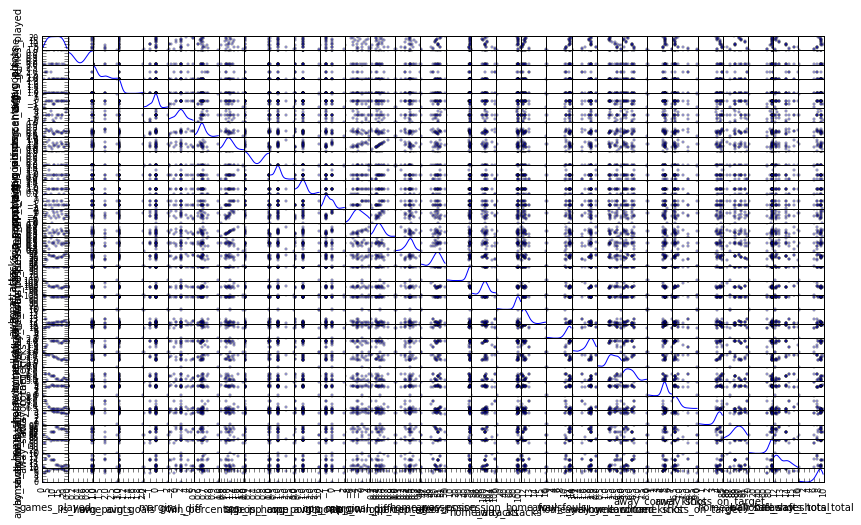

In [19]:
#This takes forever
#pd.scatter_matrix(X, alpha=0.3, figsize = (14,8), diagonal = 'kde');

In [115]:
# SVM Model with ALL FEATURES NORMALIZED
"""parameters = {'kernel': ('linear', 'rbf'), 'C': [1, 10]}
svr_2 = SVC()
clf_2 = grid_search.GridSearchCV(svr_2, parameters)
X_train, X_test, y_train, y_test = train_test_split(norm_data, y, test_size=0.2, random_state=42)
train_f1_score, test_f1_score = train_predict(clf_2, X_train, y_train, X_test, y_test)
print("F1 score for training set: {}".format(train_f1_score))
print("F1 score for test set: {}".format(test_f1_score))"""

 ~~~~~~~~~~~~~~~~~~~~~~~ 
 ~~~~~~~~~~~~~~~~~~~~~~~ 
F1 score for training set: 0.4081845835
F1 score for test set: 0.4126801888


In [116]:
"""from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
print(norm_data.shape)
X_best = SelectKBest(chi2, k=1).fit_transform(norm_data, y)
print(X_best.shape)"""

(428, 30)
(428, 1)


In [117]:
# SVM Model with BEST FEATURES
"""parameters = {'kernel': ('linear', 'rbf'), 'C': [1, 10]}
svr_3 = SVC()
clf_best = grid_search.GridSearchCV(svr_3, parameters)
X_train, X_test, y_train, y_test = train_test_split(X_best, y, test_size=0.2, random_state=42)
train_f1_score, test_f1_score = train_predict(clf_best, X_train, y_train, X_test, y_test)
print("F1 score for training set: {}".format(train_f1_score))
print("F1 score for test set: {}".format(test_f1_score))"""

 ~~~~~~~~~~~~~~~~~~~~~~~ 
 ~~~~~~~~~~~~~~~~~~~~~~~ 
F1 score for training set: 0.4081845835
F1 score for test set: 0.4126801888
